In [4]:

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O ~/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O ~/tmp/cats_and_dogs_filtered.zip


--2020-02-03 20:37:10--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response...200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/home/lee/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/home/lee/tmp/incep 100%[===================>]  83.84M  3.11MB/s    in 24s     

2020-02-03 20:37:34 (3.48 MB/s) - ‘/home/lee/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

--2020-02-03 20:37:35--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... 

In [6]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

tmp_dir = os.path.expanduser('~/tmp')
try: 
    os.mkdir(tmp_dir)
except: 
    pass

local_weights_file = os.path.join(tmp_dir, 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

_____________________________________________________________________________
conv2d_351 (Conv2D)             (None, 7, 7, 192)    147456      average_pooling2d_33[0][0]       
__________________________________________________________________________________________________
batch_normalization_342 (BatchN (None, 7, 7, 192)    576         conv2d_342[0][0]                 
__________________________________________________________________________________________________
batch_normalization_345 (BatchN (None, 7, 7, 192)    576         conv2d_345[0][0]                 
__________________________________________________________________________________________________
batch_normalization_350 (BatchN (None, 7, 7, 192)    576         conv2d_350[0][0]                 
__________________________________________________________________________________________________
batch_normalization_351 (BatchN (None, 7, 7, 192)    576         conv2d_351[0][0]                 
_______________________________

In [7]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

tmp_dir = os.path.expanduser('~/tmp')
try: 
    os.mkdir(tmp_dir)
except: 
    pass

local_zip = os.path.join(tmp_dir, 'cats_and_dogs_filtered.zip')

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall(tmp_dir)
zip_ref.close()

# Define our example directories and files
base_dir = os.path.join(tmp_dir, 'cats_and_dogs_filtered')

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/20
100/100 - 27s - loss: 0.4924 - acc: 0.7695 - val_loss: 0.3000 - val_acc: 0.9050
Epoch 2/20
100/100 - 22s - loss: 0.3778 - acc: 0.8345 - val_loss: 0.3103 - val_acc: 0.9300
Epoch 3/20
100/100 - 22s - loss: 0.3270 - acc: 0.8510 - val_loss: 0.2492 - val_acc: 0.9500
Epoch 4/20
100/100 - 22s - loss: 0.3176 - acc: 0.8600 - val_loss: 0.5868 - val_acc: 0.9120
Epoch 5/20
100/100 - 22s - loss: 0.2953 - acc: 0.8795 - val_loss: 0.2971 - val_acc: 0.9500
Epoch 6/20
100/100 - 23s - loss: 0.2934 - acc: 0.8800 - val_loss: 0.3828 - val_acc: 0.9420
Epoch 7/20
100/100 - 20s - loss: 0.2704 - acc: 0.8910 - val_loss: 0.3673 - val_acc: 0.9510
Epoch 8/20
100/100 - 18s - loss: 0.2857 - acc: 0.8835 - val_loss: 0.2788 - val_acc: 0.9590
Epoch 9/20
100/100 - 19s - loss: 0.2817 - acc: 0.8850 - val_loss: 0.5055 - val_acc: 0.9370
Epoch 10/20


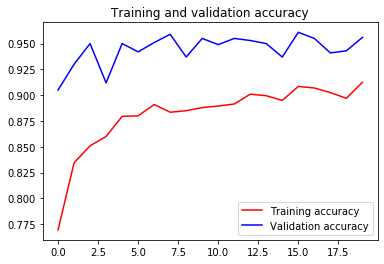

<Figure size 432x288 with 0 Axes>

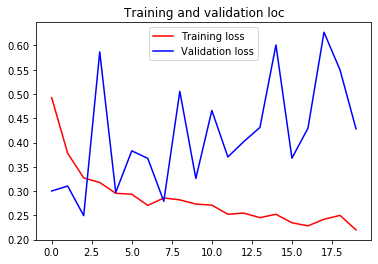

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loc')
plt.legend(loc=0)
plt.figure()


plt.show()